In [1]:
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import math
import gtsam
import json

import matplotlib.pyplot as plt
import gtsam.utils.plot as gtsam_plot

## load a trace

This trace was produced by a vehicle model.

In [2]:
with open('data/path_to_goal_2.json') as json_file:
    raw_trace = json.load(json_file)

## prepare trace

Simulate odometry and gps.

In [3]:
trace = {}

In [4]:
def simulate_odometry(x_y_psi):
    # simulate odometry
    x_y_psi_delta = np.diff( x_y_psi, axis=0 )
    d_delta   = np.sqrt( x_y_psi_delta[:,0]**2 + x_y_psi_delta[:,1]**2 )
    psi_delta = x_y_psi_delta[:,2]

    d_psi_delta = np.array([ d_delta, psi_delta  ]).transpose()  # aka odemetry
    
    return x_y_psi_delta, d_psi_delta


In [5]:
n_raw = len(raw_trace['X'])
I_subsample_raw = np.linspace(0, n_raw-1, 100, dtype=np.int32)
#I_subsample_raw = np.linspace(0, n_raw-1, 20, dtype=np.int32)
#I_subsample_raw = np.linspace(0, 100-1, 6, dtype=np.int32)

x_y_psi = np.array( [ raw_trace['X'], raw_trace['Y'], raw_trace['PSI'] ] ).transpose()
x_y_psi = x_y_psi[ I_subsample_raw, : ]

trace['x_y_psi'] = x_y_psi
trace['x_y_psi_delta'], trace['odometry'] = simulate_odometry( trace['x_y_psi'] )

trace['odometry_noise'] = [ 0.1, 0.0001, 0.1 ]
trace['x_y_psi_noise'] =       [ 0.2, 0.2, 1000 ]

# simulate GPS
gps_subsamples = np.linspace( 1, len(x_y_psi)-1, 5, dtype=np.int32 )
trace['gps_subsamples'] = gps_subsamples # e.g. [0, 5] 


gps_subsamples

array([ 1, 25, 50, 74, 99], dtype=int32)

## routines to simulate landmarks

In [6]:
def np_normalize_angle_mpi_to_pi(angle):
    angle_out = angle.copy()
    
    I_too_small = np.where( angle < np.deg2rad(-180) )[0]
    angle_out[I_too_small] = angle[I_too_small] + np.deg2rad(360)
    
    I_too_big = np.where( angle > np.deg2rad(180) )[0]
    angle_out[I_too_big] = angle[I_too_big] - np.deg2rad(360)

    return angle_out

# test: should be [10.0, -80.0, 178.0, -178.0]
# a = np_normalize_angle_mpi_to_pi( np.deg2rad( np.array([  10.0, -80.0, -182, 182 ]) ) )
# np.rad2deg(a).tolist()

In [7]:
def find_sense_landmark_on_given_trace( 
    x_y_psi, landmark_xy, 
    angular_range=np.deg2rad(80), 
    max_distance=8 
):
    
    # simulate landmark detecting sensor
    delta_x = landmark_xy[0] - x_y_psi[ :,0 ]
    delta_y = landmark_xy[1] - x_y_psi[ :,1 ]

    bearing_angle    = np_normalize_angle_mpi_to_pi(
        np.arctan2( delta_y, delta_x ) - x_y_psi[ :,2 ]
    )
    bearing_distance = np.sqrt( delta_x**2 + delta_y**2 )

    I_seen_in_front_of_vehicle = np.where( 
        np.logical_and(
            bearing_angle <   angular_range, 
            bearing_angle > - angular_range
        )  
    )[0]
    
    I_tmp = np.where( bearing_distance[I_seen_in_front_of_vehicle] < max_distance )[0]

    I_low_distance_and_visible = I_seen_in_front_of_vehicle[I_tmp]

    #
    n_observations_per_landmark = len(I_low_distance_and_visible)
    
    return n_observations_per_landmark, I_low_distance_and_visible, bearing_angle[I_low_distance_and_visible], bearing_distance[I_low_distance_and_visible]



## define some landmarks 

Define ground truth and generate observation data by simulation.

In [8]:
landmarks_gt = [
    [ 1, 10.0, 0.0 ],
    [ 2, 9.0, 5.0 ],
    [ 3, 20.0, 10.0 ],
]

landmarks_bearing = None
landmarks_observations_by_id = {}

for i, landmark_gt in enumerate(landmarks_gt):
    
    landmark_xy_gt = [ landmark_gt[1], landmark_gt[2] ]
    landmark_id   =   int(landmark_gt[0])

    n_observations_per_landmark, I_low_distance_and_visible, bearing_angle, bearing_distance = find_sense_landmark_on_given_trace( 
        trace['x_y_psi'], 
        landmark_xy_gt 
    )


    landmark_bearing = np.array([ 
        landmark_id*np.ones(n_observations_per_landmark),
        I_low_distance_and_visible,
        bearing_angle,
        bearing_distance 
    ]).transpose()
    
    landmarks_observations_by_id[ landmark_id ] = {
        'I_low_distance_and_visible' : I_low_distance_and_visible,  # the indices of the samples in the trace at which the landmark was seen.
        'landmark_bearing' : landmark_bearing,
        'landmark_bearing_info' : 'matrix with columns: landmark_id, I_low_distance_and_visible, bearing_angle, bearing_distance',
        'landmark_gt' : landmark_gt,
        'landmark_xy_gt' : landmark_xy_gt,
    }

    if i==0:
        landmarks_bearing = landmark_bearing
    else:
        landmarks_bearing = np.concatenate(( landmarks_bearing, landmark_bearing ))

    
    
trace['bearing_noise'] =       [ 0.01, 0.4 ]
trace['landmark_bearing'] = landmarks_bearing

#landmarks_bearing

## plot the visibility of a selected landmark

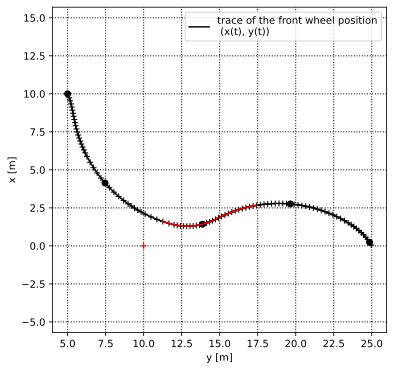

In [9]:
# plot the results

landmark_id_to_show=1

x_y_psi = trace['x_y_psi']

plt.figure(figsize=(6, 6), dpi=100)
plt.plot( x_y_psi[ :,0 ], x_y_psi[ :,1 ], 'k' )
plt.plot( x_y_psi[ :,0 ], x_y_psi[ :,1 ], '+k' )
plt.plot( x_y_psi[ :,0 ][gps_subsamples], x_y_psi[ :,1 ][gps_subsamples], 'ok' )

# get the indices of the samples in the trace at which the landmark was seen.
I_low_distance_and_visible = landmarks_observations_by_id[landmark_id_to_show]['I_low_distance_and_visible']

plt.plot( x_y_psi[ :,0 ][I_low_distance_and_visible], x_y_psi[ :,1 ][I_low_distance_and_visible], 'r' )

landmark_xy_gt = landmarks_observations_by_id[landmark_id_to_show]['landmark_xy_gt']
plt.plot( landmark_xy_gt[0], landmark_xy_gt[1], '+', color='red' )

plt.axis('equal')
plt.grid(color='k', linestyle=':', linewidth=1)
plt.xlabel('y [m]')
plt.ylabel('x [m]')
plt.legend(['trace of the front wheel position\n (x(t), y(t))'])
plt.show()

## set-up a factor graph

In [10]:
# number of vehicle-pose nodes
n_X_nodes = len( trace['x_y_psi'] )
n_X_nodes


100

In [11]:
# find all landmarks
# This might be replaced by an clustering algortithm
if len(trace['landmark_bearing']) > 0:
    landmark_ids = np.unique( trace['landmark_bearing'][:,0] )
else:
    landmark_ids = []

landmarks_by_id = {}
for landmark_id in landmark_ids:
    landmarks_by_id[int(landmark_id)] = {
        'initial_xy' : [ math.nan, math.nan ],
        'gtsam_node_id' : int( landmark_id + 1 + n_X_nodes  + 1000 ),
    }

landmarks_by_id      

{1: {'initial_xy': [nan, nan], 'gtsam_node_id': 1102},
 2: {'initial_xy': [nan, nan], 'gtsam_node_id': 1103},
 3: {'initial_xy': [nan, nan], 'gtsam_node_id': 1104}}

In [12]:
def rotmat2d(alpha, xy):
    xy_rotated = np.array([ 
            [ np.cos(alpha), -np.sin(alpha) ],
            [ np.sin(alpha),  np.cos(alpha) ]
        ]) @ xy
    
    return xy_rotated

# test
rotmat2d( alpha = np.deg2rad(-45), xy=np.array([1.0, 0.0]) )

array([ 0.70710678, -0.70710678])

In [13]:
graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

gps_noise      = gtsam.noiseModel.Diagonal.Sigmas( trace['x_y_psi_noise'] )
odometry_noise = gtsam.noiseModel.Diagonal.Sigmas( trace['odometry_noise'] )
bearing_noise  = gtsam.noiseModel.Diagonal.Sigmas( trace['bearing_noise'] )


# add first GPS measurement
# add GPS measurements
gps_samples = trace['x_y_psi'][ trace['gps_subsamples'] ]

for gps_sample_index in trace['gps_subsamples']:
    
    absolute_measurement_sample = trace['x_y_psi'][gps_sample_index]
    
    prior_mean = gtsam.Pose2( absolute_measurement_sample[0], absolute_measurement_sample[1], absolute_measurement_sample[2]+np.deg2rad(0.0)   )
    graph.add(gtsam.PriorFactorPose2(gps_sample_index+1, prior_mean, gps_noise))
    

# build odometry chain
for i, odometry_sample in enumerate( trace['odometry'] ):

    odometry = gtsam.Pose2( odometry_sample[0], 0.0, odometry_sample[1] )

    graph.add(gtsam.BetweenFactorPose2(
        i+1, i+2, 
        odometry,
        odometry_noise
    ))  
        
        
# fill initial values for the poses
# NoTE: here actually the GT is filled, TODO: repalce with pre-estimates OR
# at least add noise
for i, abs_pose_sample in enumerate( trace['x_y_psi'] ):        
    # add initial value
    
    noise = np.random.normal(0.0, 0.1, 3)
    abs_pose_sample_initial = abs_pose_sample #+ noise
    
    initial.insert(i+1, gtsam.Pose2( *tuple(abs_pose_sample_initial)  ))
    


for landmark_sample in trace['landmark_bearing']:
    
    landmark_id            = int(landmark_sample[0])
    seen_at_index_in_trace = int(landmark_sample[1])
    bearing_angle          = landmark_sample[2]
    bearing_distance       = landmark_sample[3]
    
    source_node = math.ceil(seen_at_index_in_trace) + 1
    dest_node   = landmarks_by_id[landmark_id]['gtsam_node_id']       # math.ceil(landmark_id) + 1 + n_X_nodes  + 1000
    
    # add node
    graph.add( gtsam.BearingRangeFactor2D( source_node, dest_node, gtsam.Rot2.fromAngle( bearing_angle ), bearing_distance, bearing_noise ) )

    # estimate an initial value for the position of the landmark; 
    # use the the 'seen from' position + the bearing vector
    x_y_psi = trace['x_y_psi'][int(seen_at_index_in_trace),:]
    
    xy_vehicle  = x_y_psi[0:2]
    psi_vehicle = x_y_psi[2]
    
    alpha = bearing_angle + psi_vehicle
    
    xy_l = rotmat2d( alpha, np.array([1.0, 0.0]) ) * bearing_distance + xy_vehicle +    np.array([1.3, 0.6])  # add some error
    
    # fill in a rough estimate for the position of the landmark, TODO: update/iterative average
    landmarks_by_id[landmark_id]['initial_xy'] = xy_l
    
    
    
# init landmark initial values
for i, landmark_id in enumerate(landmark_ids):
    
    dest_node   = landmarks_by_id[landmark_id]['gtsam_node_id']
    
    xy_l = landmarks_by_id[landmark_id]['initial_xy']
    initial.insert(dest_node,  gtsam.Point2( *tuple(xy_l) )  )
    
#graph

## run optimisation

In [14]:
# optimize using Levenberg-Marquardt optimization
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
result = optimizer.optimize()
#print("\nFinal Result:\n{}".format(result))


In [15]:
# 5. Calculate and print marginal covariances for all variables
marginals = gtsam.Marginals(graph, result)
for i in range(1, 2):
    print("X{} covariance:\n{}\n".format(i, marginals.marginalCovariance(i)))


X1 covariance:
[[ 0.04618514 -0.00143026  0.00035644]
 [-0.00143026  0.0461012  -0.0267483 ]
 [ 0.00035644 -0.0267483   0.08178076]]



## show the results

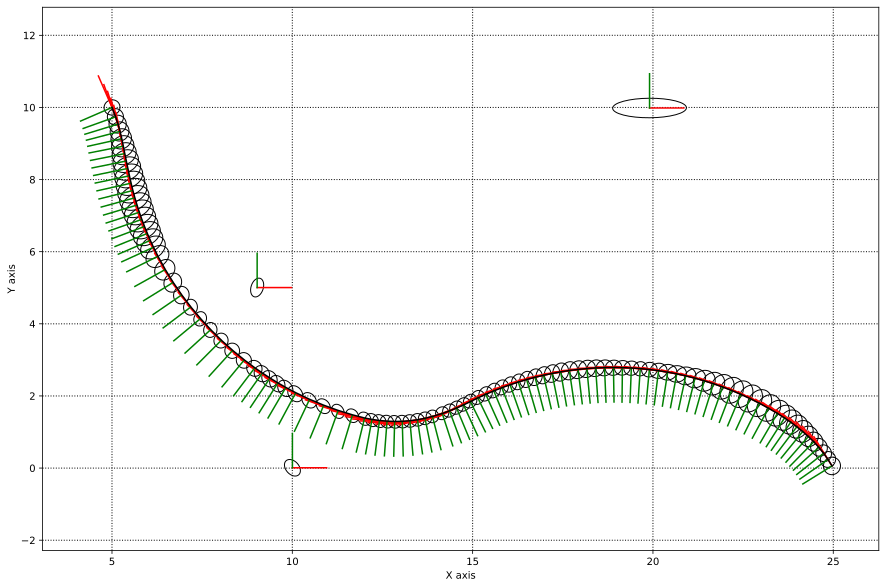

In [16]:
fig = plt.figure(0, figsize=(15,10), dpi=100)
for i in range(n_X_nodes):
    gtsam_plot.plot_pose2(0, result.atPose2(i+1), 0.95, marginals.marginalCovariance(i+1))
    
plt.plot( trace['x_y_psi'][ :,0 ], trace['x_y_psi'][ :,1 ], 'k' )

#for i in [1005, 1006]:
for (landmark_id, val) in landmarks_by_id.items():
    gtsam_node_id = val['gtsam_node_id']
    
    xy = result.atPoint2(gtsam_node_id)
    gtsam_plot.plot_pose2(0, gtsam.Pose2( xy[0], xy[1], 0.0 ), 0.95, marginals.marginalCovariance(gtsam_node_id) )
    
plt.axis('equal')
plt.grid(color='k', linestyle=':', linewidth=1)
plt.show()